In [53]:
# Import required libraries

from typing_extensions import TypedDict, List
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

import os
from langgraph.graph import StateGraph, START, END
import pprint
from IPython.display import display, Markdown, Image





In [54]:
# Define State

class CustomerSupportState(TypedDict):
    query : str
    category : str
    sentiment : List[str]
    response : str
    


In [48]:
# Define a LLM model

llm = ChatGroq(
    model = "gemma2-9b-it",
    temperature= 0,
)

result = llm.invoke("What is Agentic AI?")
pprint.pprint(result.content)

('Agentic AI refers to a type of artificial intelligence that exhibits '
 '**autonomous decision-making and goal-oriented behavior**. \n'
 '\n'
 "Here's a breakdown of the key characteristics:\n"
 '\n'
 '* **Autonomy:** Agentic AI systems can operate independently, making '
 'decisions and taking actions without constant human intervention.\n'
 '* **Goal-Oriented:** They are designed with specific goals in mind and '
 'strive to achieve them through their actions.\n'
 '* **Reactivity:** They can perceive and respond to changes in their '
 'environment, adapting their behavior accordingly.\n'
 '* **Proactiveness:**  Beyond reacting, they can also anticipate future '
 'events and take preemptive actions to achieve their goals.\n'
 '\n'
 '**Think of it like this:**\n'
 '\n'
 "Imagine a self-driving car. It's an agential AI because it:\n"
 '\n'
 '* **Operates autonomously:** It navigates roads without a human driver.\n'
 '* **Has a goal:** Its goal is to safely transport passengers to thei

In [86]:
# Create a Node function

def categorize(state: CustomerSupportState) -> CustomerSupportState:
    prompt = (
        "Categorize the following customer query into one of the following categories: Technical, Billing, or General. \n\n" f"Query: {state["query"]}\n\n"
        )
    category = llm.invoke(prompt).content.strip()
    state["category"] = category
    return state


def analyze_sentiment(state: CustomerSupportState) -> CustomerSupportState:
    prompt = (
        "Analyze the sentiment (Positive, Negative, or Neutral) of the following customer. \n\n" f"Query: {state["query"]}\n\nSentiment:",
     )
    sentiment = llm.invoke(prompt).content.strip()
    state["sentiment"] = [sentiment]
    return state

def handle_technical_query(state: CustomerSupportState) -> CustomerSupportState:
    prompt = (
        "Provide a support response to the following technical query:\n\n" f"Query:{state["query"]}\n\n"
    )
    response = llm.invoke(prompt).content.strip()
    state["response"] = response
    return state

def handle_billing_query(state: CustomerSupportState) -> CustomerSupportState:
    prompt = (
        "Provide a support response to the following billing query: \n\n" f"Query:{state["query"]}\n\n"
    )
    response = llm.invoke(prompt).content.strip()
    state["response"] = response
    return state


def handle_general_query(state: CustomerSupportState) -> CustomerSupportState:
    prompt = (
        "Provide a support response to the following general query: \n\n" f"Query:{state["query"]}\n\n"
    )
    response = llm.invoke(prompt).content.strip()
    state["response"] = response
    return state


def escalate(state: CustomerSupportState)->CustomerSupportState:
  return {"response": "This query has been escalate to a human agent due to its negative sentiment"}


def route_query(state: CustomerSupportState) -> str:
    if state["sentiment"] and state["sentiment"][0] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical_query"
    elif state["category"] == "Billing":
        return "handle_billing_query"
    else:
        return "handle_general_query"


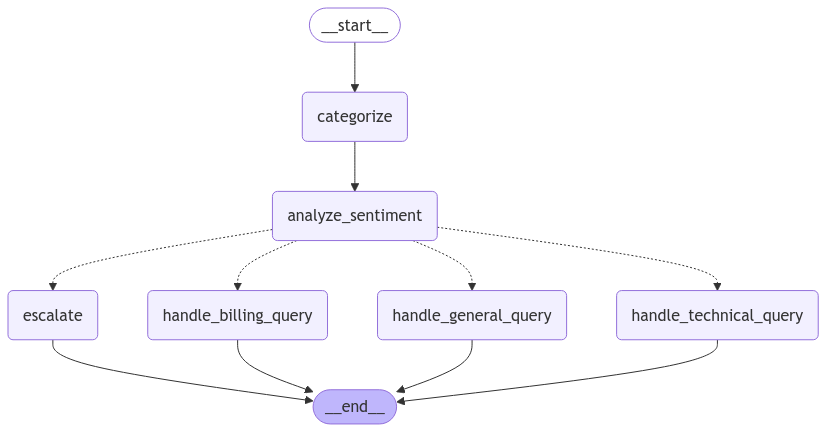

In [87]:
# Create a State Graph and workflow

customer_graph = StateGraph(CustomerSupportState)

customer_graph.add_node("categorize", categorize)
customer_graph.add_node("analyze_sentiment", analyze_sentiment)
customer_graph.add_node("handle_technical_query", handle_technical_query)
customer_graph.add_node("handle_billing_query", handle_billing_query)
customer_graph.add_node("handle_general_query", handle_general_query)
customer_graph.add_node("escalate", escalate)

customer_graph.add_edge(START, "categorize")
customer_graph.add_edge("categorize", "analyze_sentiment")
customer_graph.add_conditional_edges("analyze_sentiment",
                        route_query, 
                        {
                            "handle_technical_query" : "handle_technical_query",
                            "handle_billing_query" : "handle_billing_query",
                            "handle_general_query" : "handle_general_query",
                            "escalate": "escalate",
                        }
                        )
customer_graph.add_edge("handle_technical_query", END)
customer_graph.add_edge("handle_billing_query", END)
customer_graph.add_edge("handle_general_query", END)
customer_graph.add_edge("escalate", END)

customer_support_app = customer_graph.compile()

display(Image(customer_support_app.get_graph().draw_mermaid_png()))

In [88]:
def test_customer_support_app(query: str):
    result = customer_support_app.invoke({"query": query})
    return {
        "category": result["category"],
        "sentiment": result["sentiment"],
        "response": result["response"]
    }

In [91]:
query = "I have issue with my medical device patient monitor GE BM5000 Monitor, troubleshoot it"
result = test_customer_support_app(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Query: I have issue with my medical device patient monitor GE BM5000 Monitor, troubleshoot it
Category: **Technical** 

The query clearly indicates a problem with a specific medical device (GE BM5000 Monitor) and requests troubleshooting assistance.
Sentiment: ['The sentiment is **Negative**. \n\nHere\'s why:\n\n* **"Issue"**  implies a problem or dissatisfaction.\n* **"Troubleshoot it"** suggests the customer is experiencing difficulty and needs help resolving the issue. \n\n\nThe customer is clearly not happy with their medical device and is seeking assistance.']
Response: I understand you're having trouble with your GE BM5000 patient monitor. I'm sorry to hear that! 

To help me troubleshoot the issue, please provide me with more details:

* **What specific problem are you experiencing?** 
    * Is there an error message? 
    * Are readings inaccurate? 
    * Is the device not powering on?
* **What have you already tried to do to resolve the issue?**
* **What is the model number of